### Data Loading and Initial Checks

In this step we will:  
- Load the dataset from the SQLite database.  
- Clean the column names (make them lowercase and consistent).  
- Inspect the dataset shape (number of rows and columns).  
- Print the first few rows to understand the structure.  
- Check the data types of all columns to see which are numerical, categorical, or potential target variables.  


In [6]:
import pandas as pd, sqlite3
from pathlib import Path

# paths
csv_path = Path("../data/raw/diabetes_prediction_dataset.csv")
db_path = Path("../data/raw/Diabetes_data.db")
table_name = "diabetes"

# load csv
df_csv = pd.read_csv(csv_path)

# write to sqlite
with sqlite3.connect(db_path) as conn:
    df_csv.to_sql(table_name, conn, if_exists="replace", index=False)

# read back from sqlite
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '_')

# show shape
print("Dataset shape:", df.shape)

# print first 5 rows
print("\nFirst rows:")
print(df.head())

# print data types
print("\nData types:")
print(df.dtypes)

Dataset shape: (100000, 9)

First rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   hba1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Data types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
hba1c_level            float64
blood_glucose_l

### Conclusion: Data Types and Structure

- The dataset contains **100,000 rows and 9 columns**.  
- Categorical features: `gender`, `smoking_history`.  
- Numerical features: `age`, `bmi`, `hba1c_level`, `blood_glucose_level`.  
- Binary indicator features: `hypertension`, `heart_disease`.  
- Target: `diabetes` (0 = non-diabetic, 1 = diabetic).  

The dataset is **complete** (no missing values), the data types are appropriate for preprocessing, and the structure is ready for further cleaning and encoding.  

### Preprocessing: Gender and Smoking History

- The original dataset contained several overlapping or unclear categories in `smoking_history`  
  (`never`, `No Info`, `former`, `ever`, `not current`, `current`).  
- These were simplified into **four categories**:  
  - `never` = never smoked  
  - `past` = former smoker (including "ever" and "not current")  
  - `current` = currently smoking  
  - `unknown` = no information available  

- For `gender`, the values `Female`, `Male`, and `Other` were found.  
- The category `Other` was recoded to `Unknown` for consistency.  

This cleaning step makes the categorical data easier to interpret and reduces noise in the model training.


In [ ]:
import pandas as pd

# reload the dataset
df_new = pd.read_csv("../data/raw/diabetes_prediction_dataset.csv")

# make a clean copy
df_clean = df_new.copy()

# clean smoking_history
df_clean["smoking_history"] = df_clean["smoking_history"].replace({
    "never": "never",
    "No Info": "unknown",
    "current": "current",
    "former": "past",
    "ever": "past",        
    "not current": "past"  
})

# Clean gender (Other → Unknown)
df_clean["gender"] = df_clean["gender"].replace({
    "Other": "Unknown"
})

# check result
print("Gender:", df_clean["gender"].unique())
print("Smoking history:", df_clean["smoking_history"].unique())


Gender: ['Female' 'Male' 'Unknown']
Smoking history: ['never' 'unknown' 'current' 'past']


### Conclusion on Cleaning Categorical Features

- **Gender** now contains only three clear categories: `Female`, `Male`, and `Unknown`.  
- **Smoking history** is simplified to four categories: `never`, `past`, `current`, `unknown`.  
- This preprocessing improves **clarity, reduces redundancy**, and ensures that the one-hot encoding step does not create too many sparse or overlapping columns.  
- The model will now use **clean, interpretable categories** that better reflect real-world scenarios.  


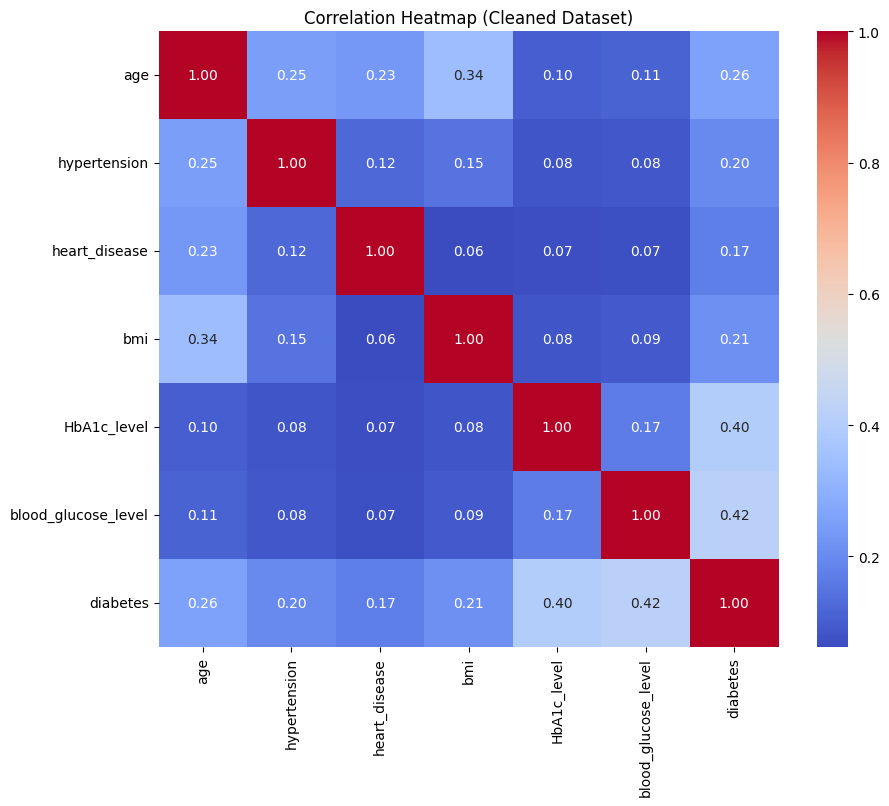

/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_6612/441719535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")


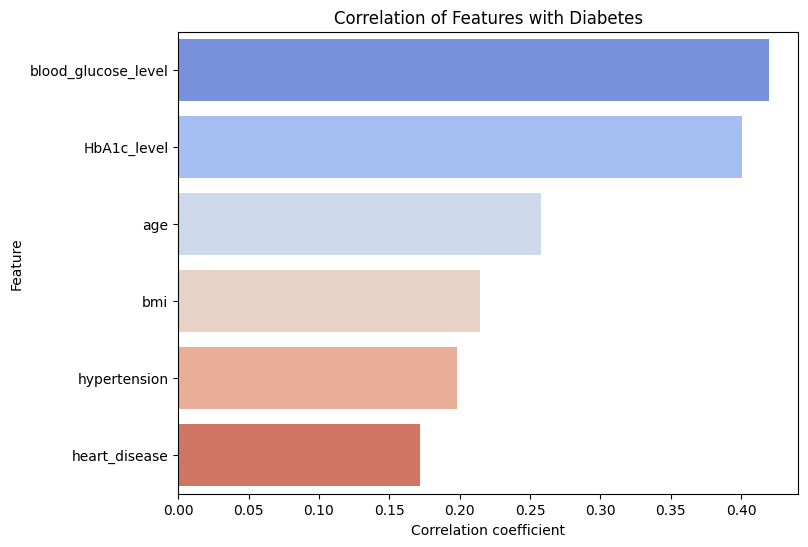

In [11]:
# correlation matrix (numeric only)
corr = df_clean.corr(numeric_only=True)

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Cleaned Dataset)")
plt.show()

# bar chart: correlation with target 'diabetes'
corr_target = corr["diabetes"].drop("diabetes").sort_values(key=abs, ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")
plt.title("Correlation of Features with Diabetes")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

### Conclusion from Correlation Analysis

- The strongest correlations with diabetes are found in **blood_glucose_level (0.42)** and **HbA1c_level (0.40)**.  
  - These features are directly used in clinical diagnosis of diabetes.  
  - They may introduce **data leakage** if included in the model.  

- Demographic and health-related features show weaker but still meaningful correlations:  
  - **Age (0.26)**  
  - **BMI (0.21)**  
  - **Hypertension (0.20)**  
  - **Heart disease (0.17)**  

- These weaker features are more suitable for building a **realistic predictive model**, as they represent risk factors rather than direct diagnostic markers.  

- Overall:  
  - Using **all features** will give higher accuracy but risks leakage.  
  - Using **only non-leakage features (age, BMI, hypertension, heart disease, smoking)** results in lower accuracy but creates a fairer, real-world applicable model.  

We're going to explore **both versions** later on:  
1. A model with all features to show maximum performance.  
2. A model without HbA1c and glucose to show ethical and practical considerations.  
